# Drive Connection :

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/cityscape/gtFine_trainvaltest.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: gtFine/test/berlin/berlin_000117_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000114_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000434_000019_gtFine_labelIds.png  
  inflating: gtFine/test/berlin/berlin_000420_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000483_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000420_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000254_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000490_000019_gtFine_color.png  
  inflating: gtFine/test/berlin/berlin_000448_000019_gtFine_polygons.json  
  inflating: gtFine/test/berlin/berlin_000099_000019_gtFine_labelIds.png  
  inflating: gtFine/test/berlin/berlin_000068_000019_gtFine_instanceIds.png  
  inflating: gtFine/test/berlin/berlin_000288_000019_gtFine_instanceIds.png  
  inflating: gtFine/test

In [ ]:
!unzip /content/gdrive/MyDrive/cityscape/leftImg8bit_trainvaltest.zip

Streaming output truncated to the last 5000 lines.
 extracting: leftImg8bit/train/jena/jena_000074_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000040_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000020_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000030_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000005_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000059_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000100_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000034_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000089_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000104_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000107_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000080_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000006_000019_leftImg8bit.png  


# Verify gpu:

In [ ]:
!nvidia-smi

Sat Aug  7 15:48:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    29W /  70W |  13040MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Remove folder**

In [ ]:
import shutil
path=''
shutil.rmtree(path)

# Libraries Importation :

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torchvision.transforms.functional as TF
from collections import namedtuple
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import os.path
from torch.autograd import Variable
import torchvision.utils as v_utils
import time
import torchvision
import torch.backends.cudnn as cudnn
import cv2
import math
import torch.nn.functional as F
from os import listdir
from os.path import isfile, join, isdir
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
from torchvision.utils import save_image
import csv
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install torchsummary

In [ ]:
!pip install torchviz

# Importation Cityscape Dataset :

In [ ]:
class CityscapesDataset(Dataset):

    def __init__(self, root, split='train', mode='fine', augment=False):

        self.root = os.path.expanduser(root)
        self.mode = 'gtFine' if mode == 'fine' else 'gtCoarse'
        self.images_dir = os.path.join(self.root, 'leftImg8bit', split)
        self.targets_dir = os.path.join(self.root, self.mode, split)
        self.split = split
        self.augment = augment
        self.images = []
        self.targets = []
        self.mapping = {
            0: 0,  # unlabeled
            1: 0,  # ego vehicle
            2: 0,  # rect border
            3: 0,  # out of roi
            4: 0,  # static
            5: 0,  # dynamic
            6: 0,  # ground
            7: 1,  # road
            8: 0,  # sidewalk
            9: 0,  # parking
            10: 0,  # rail track
            11: 0,  # building
            12: 0,  # wall
            13: 0,  # fence
            14: 0,  # guard rail
            15: 0,  # bridge
            16: 0,  # tunnel
            17: 0,  # pole
            18: 0,  # polegroup
            19: 0,  # traffic light
            20: 0,  # traffic sign
            21: 0,  # vegetation
            22: 0,  # terrain
            23: 2,  # sky
            24: 0,  # person
            25: 0,  # rider
            26: 3,  # car
            27: 0,  # truck
            28: 0,  # bus
            29: 0,  # caravan
            30: 0,  # trailer
            31: 0,  # train
            32: 0,  # motorcycle
            33: 0,  # bicycle
            -1: 0  # licenseplate
        }
        self.mappingrgb = {
            0: (255, 0, 0),  # unlabeled
            1: (255, 0, 0),  # ego vehicle
            2: (255, 0, 0),  # rect border
            3: (255, 0, 0),  # out of roi
            4: (255, 0, 0),  # static
            5: (255, 0, 0),  # dynamic
            6: (255, 0, 0),  # ground
            7: (0, 255, 0),  # road
            8: (255, 0, 0),  # sidewalk
            9: (255, 0, 0),  # parking
            10: (255, 0, 0),  # rail track
            11: (255, 0, 0),  # building
            12: (255, 0, 0),  # wall
            13: (255, 0, 0),  # fence
            14: (255, 0, 0),  # guard rail
            15: (255, 0, 0),  # bridge
            16: (255, 0, 0),  # tunnel
            17: (255, 0, 0),  # pole
            18: (255, 0, 0),  # polegroup
            19: (255, 0, 0),  # traffic light
            20: (255, 0, 0),  # traffic sign
            21: (255, 0, 0),  # vegetation
            22: (255, 0, 0),  # terrain
            23: (0, 0, 255),  # sky
            24: (255, 0, 0),  # person
            25: (255, 0, 0),  # rider
            26: (255, 255, 0),  # car
            27: (255, 0, 0),  # truck
            28: (255, 0, 0),  # bus
            29: (255, 0, 0),  # caravan
            30: (255, 0, 0),  # trailer
            31: (255, 0, 0),  # train
            32: (255, 0, 0),  # motorcycle
            33: (255, 0, 0),  # bicycle
            -1: (255, 0, 0)  # licenseplate
        }

        # Ensure that this matches the above mapping!#!@#!@#
        # For example 4 classes, means we should map to the ids=(0,1,2,3)
        # This is used to specify how many outputs the network should product...
        self.num_classes = 4

        # =============================================
        # Check that inputs are valid
        # =============================================
        if mode not in ['fine', 'coarse']:
            raise ValueError('Invalid mode! Please use mode="fine" or mode="coarse"')
        if mode == 'fine' and split not in ['train', 'test', 'val']:
            raise ValueError('Invalid split for mode "fine"! Please use split="train", split="test" or split="val"')
        elif mode == 'coarse' and split not in ['train', 'train_extra', 'val']:
            raise ValueError('Invalid split for mode "coarse"! Please use split="train", split="train_extra" or split="val"')
        if not os.path.isdir(self.images_dir) or not os.path.isdir(self.targets_dir):
            raise RuntimeError('Dataset not found or incomplete. Please make sure all required folders for the'
                               ' specified "split" and "mode" are inside the "root" directory')

        # =============================================
        # Read in the paths to all images
        # =============================================
        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            target_dir = os.path.join(self.targets_dir, city)
            for file_name in os.listdir(img_dir):
                self.images.append(os.path.join(img_dir, file_name))
                target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0], '{}_labelIds.png'.format(self.mode))
                # target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0], '{}_color.png'.format(self.mode))
                self.targets.append(os.path.join(target_dir, target_name))

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of images: {}\n'.format(self.__len__())
        fmt_str += '    Split: {}\n'.format(self.split)
        fmt_str += '    Mode: {}\n'.format(self.mode)
        fmt_str += '    Augment: {}\n'.format(self.augment)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        return fmt_str

    def __len__(self):
        return len(self.images)

    def mask_to_class(self, mask):
        '''
        Given the cityscapes dataset, this maps to a 0..classes numbers.
        This is because we are using a subset of all masks, so we have this "mapping" function.
        This mapping function is used to map all the standard ids into the smaller subset.
        '''
        maskimg = torch.zeros((mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in self.mapping:
            maskimg[mask == k] = self.mapping[k]
        return maskimg

    def mask_to_rgb(self, mask):
        '''
        Given the Cityscapes mask file, this converts the ids into rgb colors.
        This is needed as we are interested in a sub-set of labels, thus can't just use the
        standard color output provided by the dataset.
        '''
        rgbimg = torch.zeros((3, mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in self.mappingrgb:
            rgbimg[0][mask == k] = self.mappingrgb[k][0]
            rgbimg[1][mask == k] = self.mappingrgb[k][1]
            rgbimg[2][mask == k] = self.mappingrgb[k][2]
        return rgbimg

    def class_to_rgb(self, mask):
        '''
        This function maps the classification index ids into the rgb.
        For example after the argmax from the network, you want to find what class
        a given pixel belongs too. This does that but just changes the color
        so that we can compare it directly to the rgb groundtruth label.
        '''
        mask2class = dict((v, k) for k, v in self.mapping.items())
        rgbimg = torch.zeros((3, mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in mask2class:
            rgbimg[0][mask == k] = self.mappingrgb[mask2class[k]][0]
            rgbimg[1][mask == k] = self.mappingrgb[mask2class[k]][1]
            rgbimg[2][mask == k] = self.mappingrgb[mask2class[k]][2]
        return rgbimg

    def __getitem__(self, index):

        # first load the RGB image
        image = Image.open(self.images[index]).convert('RGB')

        # next load the target
        target = Image.open(self.targets[index]).convert('L')

        # If augmenting, apply random transforms
        # Else we should just resize the image down to the correct size
        if self.augment:
            # Resize
            image = TF.resize(image, size=(128+10, 256+10), interpolation=Image.BILINEAR)
            target = TF.resize(target, size=(128+10, 256+10), interpolation=Image.NEAREST)
            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(128, 256))
            image = TF.crop(image, i, j, h, w)
            target = TF.crop(target, i, j, h, w)
            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                target = TF.hflip(target)
        else:
            # Resize
            image = TF.resize(image, size=(128, 256), interpolation=Image.BILINEAR)
            target = TF.resize(target, size=(128, 256), interpolation=Image.NEAREST)

        # convert to pytorch tensors
        # target = TF.to_tensor(target)
        target = torch.from_numpy(np.array(target, dtype=np.uint8))
        image = TF.to_tensor(image)

        # convert the labels into a mask
        targetrgb = self.mask_to_rgb(target)
        targetmask = self.mask_to_class(target)
        targetmask = targetmask.long()
        targetrgb = targetrgb.long()

        # finally return the image pair
        return image, targetmask, targetrgb

# Model UNET :

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
  def forward(self, x):
    return self.conv(x)

class UNET(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    # 161*161 , output: 160*160

    # Down part of UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    # Up part of UNET
    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2 , feature, kernel_size=2, stride=2,))
      self.ups.append(DoubleConv(feature*2, feature))
    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x= down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)
    return self.final_conv(x)



# Train Model UNET:

In [ ]:
class args():
  #datadir = "/content/gdrive/Shareddrives/inesk/cityscape/"
  datadir = "/content/"
  batch_size=5
  num_gpu=1
  losstype="segment"

In [ ]:
# hyper-parameters (learning rate and how many epochs we will train for)
lr = 0.0002
epochs = 100

# cityscapes dataset loading
img_data = CityscapesDataset(args.datadir, split='train', mode='fine', augment=True)
img_batch = torch.utils.data.DataLoader(img_data, batch_size=args.batch_size, shuffle=True, num_workers=4)
print(img_data)

# loss function
# use reconstruction of image if looking to match image output to another image (RGB)
# else if you have a set of classes, we want to do some binary classification on it (cityscapes classes)
if args.losstype == "reconstruction":
    recon_loss_func = nn.MSELoss()
    num_classes = 3  # red, blue, green
elif args.losstype == "segment":
    recon_loss_func = nn.CrossEntropyLoss()
    num_classes = img_data.num_classes  # background, road, sky, car
else:
    print("please select a valid loss type (reconstruction or segment)...")
    exit()

# initiate generator and optimizer
print("creating unet model...")
generator = nn.DataParallel(UNET(3, img_data.num_classes), device_ids=[i for i in range(args.num_gpu)]).cuda()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

# load pretrained model if it is there
#file_model = '/content/gdrive/Shareddrives/inesk/unet.pkl'
file_model = '/content/gdrive/MyDrive/unet.pkl'
if os.path.isfile(file_model):
    generator = torch.load(file_model)
    print("    - model restored from file....")
    print("    - filename = %s" % file_model)

# or log file that has the output of our loss
header = ['epoch', 'loss']
with open('/content/gdrive/MyDrive/unet_loss.csv', 'a', encoding='UTF8') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)

# make the result directory
if not os.path.exists('/content/gdrive/MyDrive/result/'):
    os.makedirs('/content/gdrive/MyDrive/result/')

# finally!!! the training loop!!!
for epoch in range(epochs):
    for idx_batch, (imagergb, labelmask, labelrgb) in enumerate(img_batch):
        # zero the grad of the network before feed-forward
        gen_optimizer.zero_grad()

        # send to the GPU and do a forward pass
        x = Variable(imagergb).cuda(0)
        y_ = Variable(labelmask).cuda(0)
        y = generator.forward(x)
        
        # we "squeeze" the groundtruth if we are using cross-entropy loss
        # this is because it expects to have a [N, W, H] image where the values
        # in the 2D image correspond to the class that that pixel should be 0 < pix[u,v] < classes
        if args.losstype == "segment":
            y_ = torch.squeeze(y_)

        # finally calculate the loss and back propagate
        loss = recon_loss_func(y, y_)
        loss.backward()
        gen_optimizer.step()

        # every 60 images, save the current images
        # also checkpoint the model to disk
        if idx_batch % 60 == 0:

            # nice debug print of this epoch and its loss
            print("epoch = "+str(epoch)+" | loss = "+str(loss.item()))
            data = [epoch, loss.item()]
            with open('/content/gdrive/MyDrive/unet_loss.csv', 'a', encoding='UTF8') as f:
              writer = csv.writer(f)

              # write the data
              writer.writerow(data)

            # save the original image and label batches to file
            v_utils.save_image(x.cpu().data, "/content/gdrive/MyDrive/result/original_image_{}_{}.png".format(epoch, idx_batch))
            v_utils.save_image(labelrgb.float(), "/content/gdrive/MyDrive/result/label_image_{}_{}.png".format(epoch, idx_batch))

            # max over the classes should be the prediction
            # our prediction is [N, classes, W, H]
            # so we max over the second dimension and take the max response
            # if we are doing rgb reconstruction, then just directly save it to file
            if args.losstype == "segment":
                y_threshed = torch.zeros((y.size()[0], 3, y.size()[2], y.size()[3]))
                for idx in range(0, y.size()[0]):
                    maxindex = torch.argmax(y[idx], dim=0).cpu().int()
                    y_threshed[idx] = img_data.class_to_rgb(maxindex)
                v_utils.save_image(y_threshed, "/content/gdrive/MyDrive/result/gen_image_{}_{}.png".format(epoch, idx_batch))
            else:
                v_utils.save_image(y.cpu().data, "/content/gdrive/MyDrive/result/gen_image_{}_{}.png".format(epoch, idx_batch))

            # finally checkpoint this file to disk
            torch.save(generator, file_model)

Dataset CityscapesDataset
    Number of images: 2975
    Split: train
    Mode: gtFine
    Augment: True
    Root Location: /content/

creating unet model...
epoch = 0 | loss = 1.469402551651001
epoch = 0 | loss = 0.5793380737304688
epoch = 0 | loss = 0.4090971052646637
epoch = 0 | loss = 0.44466179609298706
epoch = 0 | loss = 0.40820565819740295
epoch = 0 | loss = 0.2632019817829132
epoch = 0 | loss = 0.3466946482658386
epoch = 0 | loss = 0.38225579261779785
epoch = 0 | loss = 0.33375391364097595
epoch = 0 | loss = 0.3197523057460785
epoch = 1 | loss = 0.2017630785703659
epoch = 1 | loss = 0.29658442735671997
epoch = 1 | loss = 0.24480433762073517
epoch = 1 | loss = 0.3458561301231384
epoch = 1 | loss = 0.2656995356082916
epoch = 1 | loss = 0.17681272327899933
epoch = 1 | loss = 0.18136675655841827
epoch = 1 | loss = 0.22532984614372253
epoch = 1 | loss = 0.13260626792907715
epoch = 1 | loss = 0.16061103343963623
epoch = 2 | loss = 0.2277342975139618
epoch = 2 | loss = 0.2710756659507

# **Test Example:**

## **Original image:**

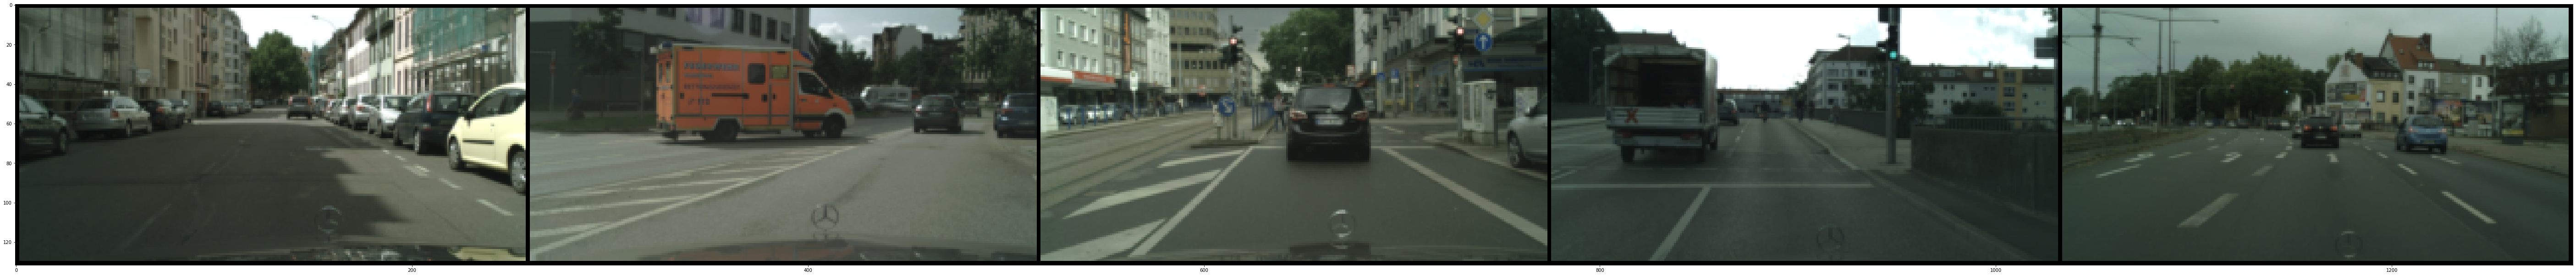

In [ ]:
img = mpimg.imread('/content/gdrive/MyDrive/result/original_image_9_540.png')
plt.figure(figsize=(100,100))
imgplot = plt.imshow(img)
plt.show()

## **Labeled image:**

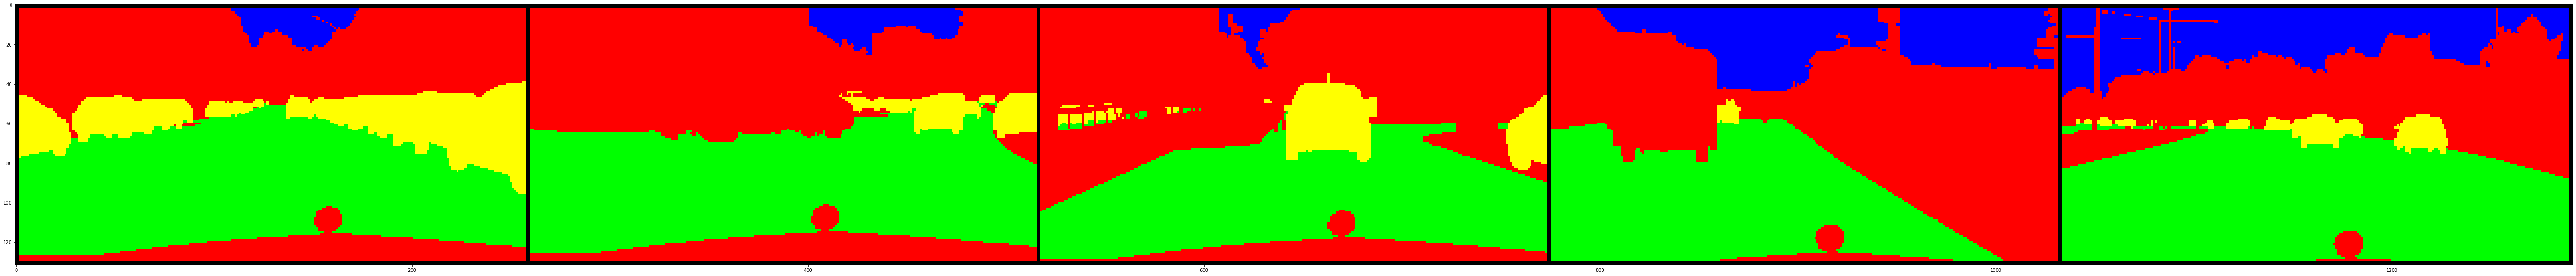

In [ ]:
img = mpimg.imread('/content/gdrive/MyDrive/result/label_image_9_540.png')
plt.figure(figsize=(100,100))
imgplot = plt.imshow(img)
plt.show()

## **Generated image:**

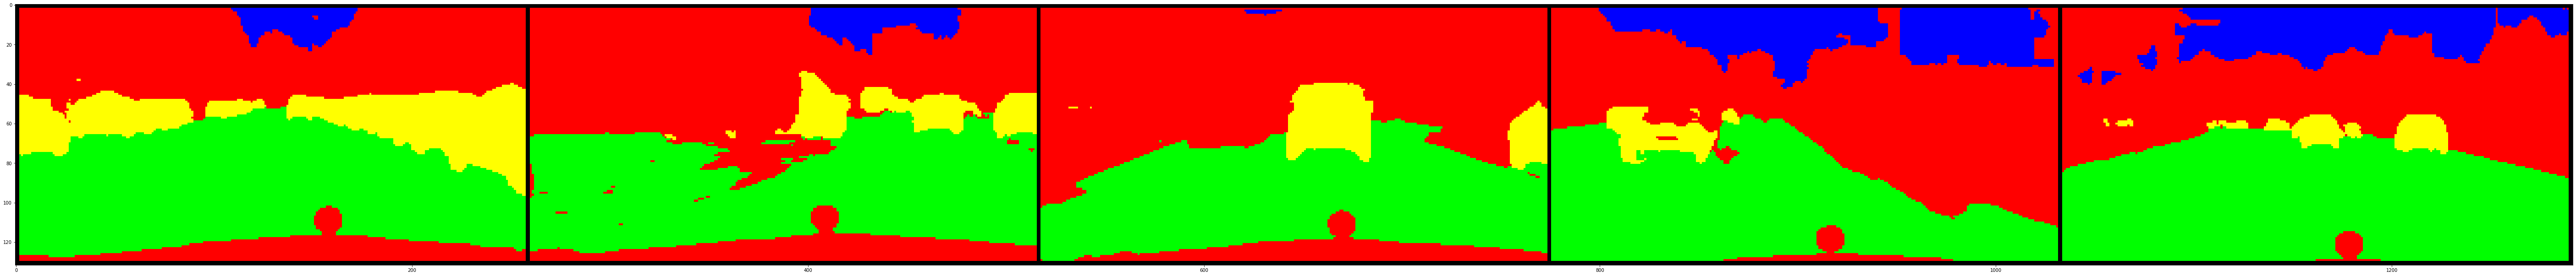

In [ ]:
img = mpimg.imread('/content/gdrive/MyDrive/result/gen_image_9_540.png')
plt.figure(figsize=(100,100))
imgplot = plt.imshow(img)
plt.show()

# Calcule Miou

In [ ]:
def calcule_miou(path, path1):
  im = Image.open(path).convert('LA')
  ar = np.asarray(im).flatten()
  im1 = Image.open(path1).convert('LA')
  ar1 = np.asarray(im1).flatten()
  dic= {0:0, 29:1, 76:2, 150:3, 226:4, 255:5 }
  ar_c = np.array([dic[ar[i]] for i in range (len(ar))])
  ar1_c = np.array([dic[ar1[i]] for i in range (len(ar1))])
  unique1, counts1 = np.unique(ar_c, return_counts=True)
  unique, counts = np.unique(ar1_c, return_counts=True)
  ar_dic = dict(zip(unique, counts))
  ar1_dic = dict(zip(unique1, counts1))
  gat = ar1_c*6+ar_c
  unique2, counts2 = np.unique(gat, return_counts=True)
  conf_c = dict(zip(unique2, counts2))
  conf = np.zeros((6,6),dtype=int)
  for i in conf_c.items(): 
    mod= i[0] % 6
    div = i[0] //6
    conf[div][mod] = i[1]
  I=conf.diagonal()
  U=counts+counts1-I
  ind=I/U
  return np.mean(ind[1:-1])

In [ ]:
i=0
a=0
for ge in sorted(listdir("/content/gdrive/MyDrive/result")):
  path = join("/content/gdrive/MyDrive/result", ge)
  if ge[0:3] == "gen":
    path1="/content/gdrive/MyDrive/result/label_image" + ge[9:]
    a+=calcule_miou(path, path1)
    i=i+1
print(a/i)
    

0.8606442027991207


# **UNET loss:**

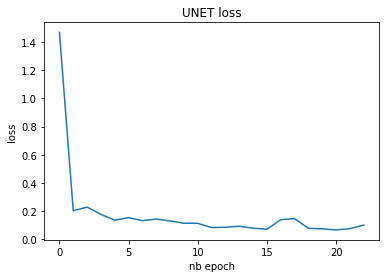

In [ ]:
with open ('/content/gdrive/MyDrive/unet_loss.csv', newline='') as myfile:
  data=list(csv.reader(myfile))
loss=np.array([float(data[i][1]) for i in range (1,len(data),10)])
epoch=np.array([float(data[i][0]) for i in range (1,len(data),10)])
plt.xlabel("nb epoch")
plt.ylabel("loss")
plt.title("UNET loss")
plt.plot(epoch,loss)

# Load Model UNET:

In [ ]:
def load_UNET():
  file_model = '/content/gdrive/MyDrive/unet.pkl'
  if os.path.isfile(file_model):
      generator = torch.load(file_model)
      print("    - model restored from file....")
      print("    - filename = %s" % file_model)
      return generator
  else:
      print("unable to load unet.pkl model file")
      return 0

# Visualisation Unet Model:

In [ ]:
from torchviz import make_dot
generator = nn.DataParallel(UNET(3, img_data.num_classes), device_ids=[i for i in range(args.num_gpu)]).cuda()
img_data = CityscapesDataset(args.datadir, split='train', mode='fine', augment=True)
img_batch = torch.utils.data.DataLoader(img_data, batch_size=args.batch_size, shuffle=True, num_workers=4)
imagergb= next(iter(img_batch ))
x = Variable(imagergb[0]).cuda(0)
out = generator.forward(x)
make_dot(out).render("/content/gdrive/MyDrive/attached", format="png")

'/content/gdrive/MyDrive/attached.png'

In [ ]:
from torchsummary import summary
your_model=load_UNET()
summary(your_model, input_size=(3, 128 , 256))

    - model restored from file....
    - filename = /content/gdrive/MyDrive/unet.pkl
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 256]           1,728
       BatchNorm2d-2         [-1, 64, 128, 256]             128
              ReLU-3         [-1, 64, 128, 256]               0
            Conv2d-4         [-1, 64, 128, 256]          36,864
       BatchNorm2d-5         [-1, 64, 128, 256]             128
              ReLU-6         [-1, 64, 128, 256]               0
        DoubleConv-7         [-1, 64, 128, 256]               0
         MaxPool2d-8          [-1, 64, 64, 128]               0
            Conv2d-9         [-1, 128, 64, 128]          73,728
      BatchNorm2d-10         [-1, 128, 64, 128]             256
             ReLU-11         [-1, 128, 64, 128]               0
           Conv2d-12         [-1, 128, 64, 128]         147,456
      BatchNorm2d-

# Test UNET Model :

In [ ]:
# cityscapes dataset loading
img_data = CityscapesDataset(args.datadir, split='val', mode='fine', augment=False)
img_batch = torch.utils.data.DataLoader(img_data, batch_size=args.batch_size, shuffle=False, num_workers=4)
print(img_data)

# initiate generator and optimizer
print("creating unet model...")
generator = nn.DataParallel(UNET(3, img_data.num_classes), device_ids=[i for i in range(args.num_gpu)]).cuda()

# load pretrained model if it is there
generator=load_UNET()

# Loop through the dataset and evaluate how well the network predicts
print("\nevaluating network (will take a while)...")
history_accuracy = []
history_time = []
for idx_batch, (imagergb, label_class, labelrgb) in enumerate(img_batch):

    # send to the GPU and do a forward pass
    start_time = time.time()
    x = Variable(imagergb).cuda(0)
    y_ = Variable(label_class).cuda(0)
    y = generator.forward(x)
    end_time = time.time()

    # we "squeeze" the groundtruth if we are using cross-entropy loss
    # this is because it expects to have a [N, W, H] image where the values
    # in the 2D image correspond to the class that that pixel should be 0 < pix[u,v] < classes
    if args.losstype == "segment":
        y_ = torch.squeeze(y_)

    # max over the classes should be the prediction
    # our prediction is [N, classes, W, H]
    # so we max over the second dimension and take the max response
    # if we are doing rgb reconstruction, then just directly save it to file
    pred_class = torch.zeros((y.size()[0], y.size()[2], y.size()[3]))
    if args.losstype == "segment":
        for idx in range(0, y.size()[0]):
            pred_class[idx] = torch.argmax(y[idx], dim=0).cpu().int()
            #pred_rgb[idx] = img_data.class_to_rgb(maxindex)
    else:
        print("this test script only works for \"segment\" unet classification...")
        exit()

    # unsqueese so we have [N, 1, W, H] size
    # this allows for debug saving of the images to file...
    pred_class = pred_class.unsqueeze(1).float()
    label_class = label_class.unsqueeze(1).float()

    # now compare the groundtruth to the predicted
    # we should record the accuracy for the class
    acc_sum = (pred_class == label_class).sum()
    acc = float(acc_sum) / (label_class.size()[0]*label_class.size()[2]*label_class.size()[3])
    history_accuracy.append(acc)
    history_time.append((end_time-start_time))

    # debug saving generated classes to file
    v_utils.save_image(pred_class.float()/img_data.num_classes, "/content/gdrive/MyDrive/test/gen_image_{}_{}.png".format(0, idx_batch))
    v_utils.save_image(label_class.float()/img_data.num_classes, "/content/gdrive/MyDrive/test/label_image_{}_{}.png".format(0, idx_batch))
    v_utils.save_image(x.cpu().data, "/content/gdrive/MyDrive/test/original_image_{}_{}.png".format(0, idx_batch))

# finally output the accuracy
print("\nNETWORK RESULTS")
print("    - avg timing = %.4f (sec)" % (sum(history_time)/len(history_time)))
print("    - avg accuracy = %.4f" % (sum(history_accuracy)/len(history_accuracy)))

Dataset CityscapesDataset
    Number of images: 500
    Split: val
    Mode: gtFine
    Augment: False
    Root Location: /content/

creating unet model...
    - model restored from file....
    - filename = /content/gdrive/MyDrive/unet.pkl

evaluating network (will take a while)...

NETWORK RESULTS
    - avg timing = 0.0256 (sec)
    - avg accuracy = 0.9439


# Test Example:

## **Original Image:**

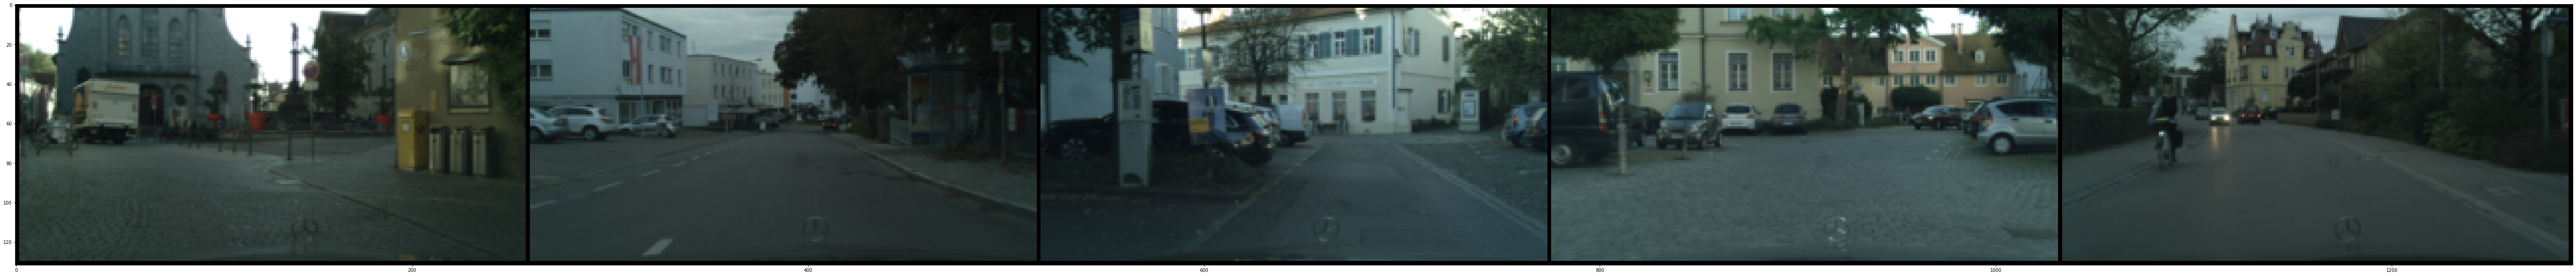

In [ ]:
img = mpimg.imread('/content/gdrive/MyDrive/test/original_image_0_99.png')
plt.figure(figsize=(100,100))
imgplot = plt.imshow(img)
plt.show()

## **Labeled Image:**

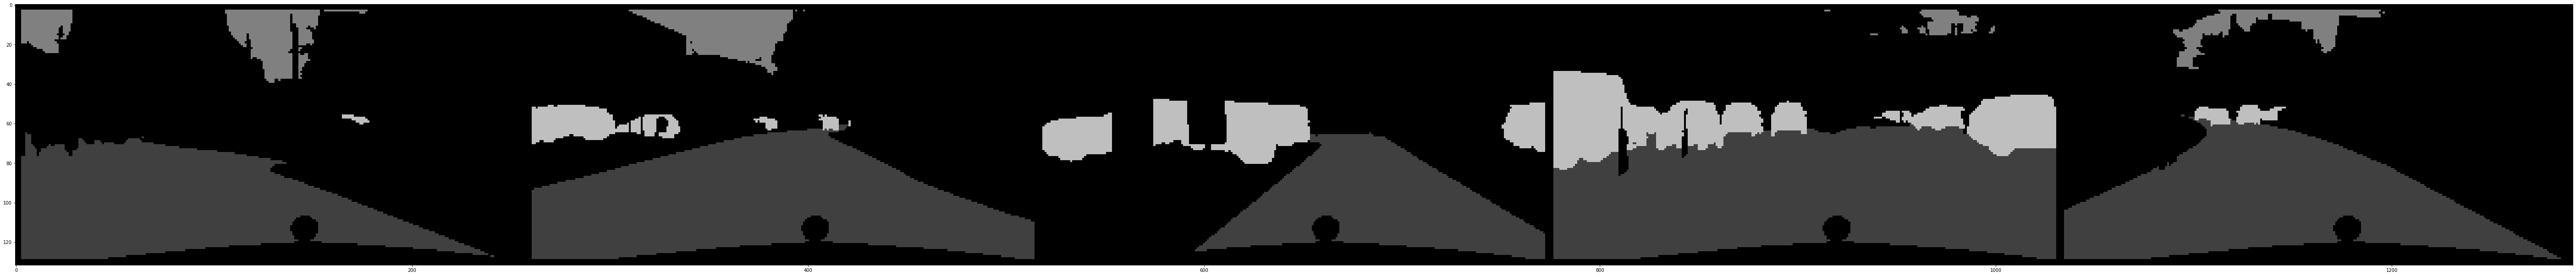

In [ ]:
img = mpimg.imread('/content/gdrive/MyDrive/test/label_image_0_99.png')
plt.figure(figsize=(100,100))
imgplot = plt.imshow(img)
plt.show()

## Generated Image:

In [ ]:
img = mpimg.imread('/content/gdrive/MyDrive/test/gen_image_0_99.png')
plt.figure(figsize=(100,100))
imgplot = plt.imshow(img)
plt.show()

# Predict UNET Model :

In [ ]:
datadir="/content/leftImg8bit/test/"

# our transform that is applied to all incoming images
transform_image = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(128, 256), interpolation=Image.BILINEAR),
    torchvision.transforms.ToTensor()
])

# load the images in the folder
img_data = torchvision.datasets.ImageFolder(root=datadir, transform=transform_image)
img_batch = torch.utils.data.DataLoader(img_data, batch_size=args.batch_size, shuffle=False, num_workers=4)
print(img_data)

# load pretrained model if it is there
print("loading unet model...")
generator=load_UNET()

# make the result directory
if not os.path.exists('/content/gdrive/MyDrive/predict/'):
    os.makedirs('/content/gdrive/MyDrive/predict/')

# Loop through the dataset and evaluate how well the network predicts
print("\nevaluating network (will take a while)...")
for idx_batch, (imagergb, labelrgb) in enumerate(img_batch):

    # send to the GPU and do a forward pass
    x = Variable(imagergb).cuda(0)
    y = generator.forward(x)

    # enforce that we are only doing segmentation network type
    if args.losstype != "segment":
        print("this test script only works for \"segment\" unet classification...")
        exit()

    # max over the classes should be the prediction
    # our prediction is [N, classes, W, H]
    # so we max over the second dimension and take the max response
    pred_class = torch.zeros((y.size()[0], y.size()[2], y.size()[3]))
    for idx in range(0, y.size()[0]):
        pred_class[idx] = torch.argmax(y[idx], dim=0).cpu().int()

    # unsqueese so we have [N, 1, W, H] size
    # this allows for debug saving of the images to file...
    pred_class = pred_class.unsqueeze(1).float()

    # debug saving generated classes to file
    v_utils.save_image(pred_class.float()/y.size()[1], "/content/gdrive/MyDrive/predict/gen_image_{}_{}.png".format(0, idx_batch))
    v_utils.save_image(x.cpu().data, "/content/gdrive/MyDrive/predict/original_image_{}_{}.png".format(0, idx_batch))

Dataset ImageFolder
    Number of datapoints: 1525
    Root location: /content/leftImg8bit/test/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
loading unet model...
    - model restored from file....
    - filename = /content/gdrive/MyDrive/unet.pkl

evaluating network (will take a while)...


# Test Example:

## **Original Image:**

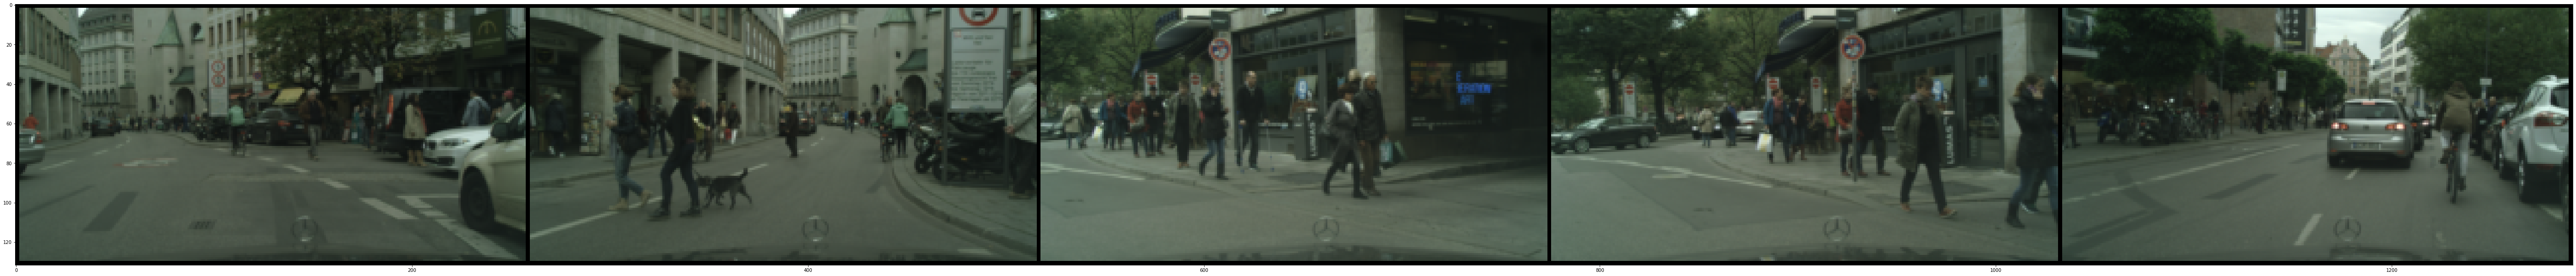

In [ ]:
img = mpimg.imread('/content/gdrive/MyDrive/predict/original_image_0_263.png')
plt.figure(figsize=(100,100))
imgplot = plt.imshow(img)
plt.show()

## Generated Image:

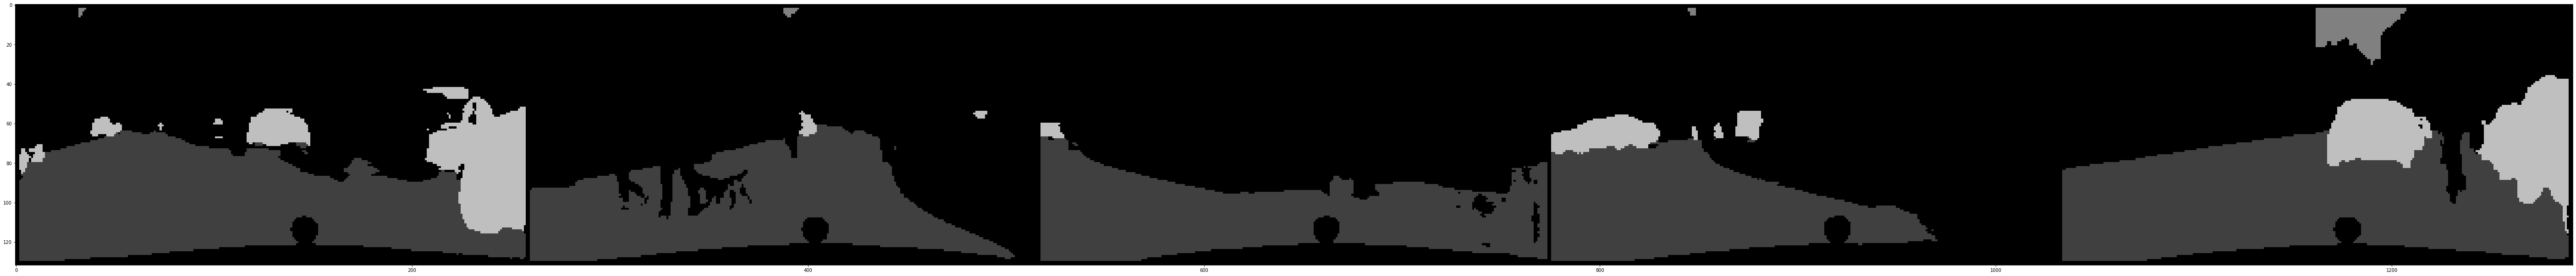

In [ ]:
img = mpimg.imread('/content/gdrive/MyDrive/predict/gen_image_0_263.png')
plt.figure(figsize=(100,100))
imgplot = plt.imshow(img)
plt.show()

# Calcule Miou

In [ ]:
def calcule_miou1(path, path1):
  im = Image.open(path).convert('LA')
  ar = np.asarray(im).flatten()
  im1 = Image.open(path1).convert('LA')
  ar1 = np.asarray(im1).flatten()
  dic= {0:0, 64:1, 128:2, 191:3, 255:4 }
  ar_c = np.array([dic[ar[i]] for i in range (len(ar))])
  ar1_c = np.array([dic[ar1[i]] for i in range (len(ar1))])
  unique1, counts1 = np.unique(ar_c, return_counts=True)
  unique, counts = np.unique(ar1_c, return_counts=True)
  ar_dic = dict(zip(unique, counts))
  ar1_dic = dict(zip(unique1, counts1))
  gat = ar1_c*5+ar_c
  unique2, counts2 = np.unique(gat, return_counts=True)
  conf_c = dict(zip(unique2, counts2))
  conf = np.zeros((5,5),dtype=int)
  for i in conf_c.items(): 
    mod= i[0] % 5
    div = i[0] //5
    conf[div][mod] = i[1]
  I=conf.diagonal()
  U=counts+counts1-I
  ind=I/U
  return np.mean(ind[1::])

In [ ]:
i=0
a=0
for ge in sorted(listdir("/content/gdrive/MyDrive/test")):
  path = join("/content/gdrive/MyDrive/test", ge)
  if ge[0:3] == "gen":
    path1="/content/gdrive/MyDrive/test/label_image" + ge[9:]
    a+=calcule_miou1(path, path1)
    i=i+1
print(a/i)

0.8725220932355381


# Discriminator Model :

In [ ]:
class s4GAN_discriminator(nn.Module):

    def __init__(self, num_classes, ndf = 64):
        super(s4GAN_discriminator, self).__init__()

        self.conv1 = nn.Conv2d(num_classes, ndf, kernel_size=4, stride=2, padding=1) # 160 x 160
        self.conv2 = nn.Conv2d(  ndf, ndf*2, kernel_size=4, stride=2, padding=1) # 80 x 80
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1) # 40 x 40
        self.conv4 = nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1) # 20 x 20
        self.avgpool = nn.AvgPool2d((16, 32))
        self.fc = nn.Linear(ndf*8, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.drop = nn.Dropout2d(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
       
        x = self.conv1(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
       
        x = self.conv2(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.conv3(x)
        x = self.leaky_relu(x)
        x = self.drop(x)
        
        x = self.conv4(x)
        x = self.leaky_relu(x)
        
        maps = self.avgpool(x)
        conv4_maps = maps 
        out = maps.view(maps.size(0), -1)
        out = self.sigmoid(self.fc(out))
        
        return out, conv4_maps

# Concatination 2 Images :

In [ ]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

In [ ]:
loader = transforms.Compose([transforms.ToTensor()])

In [ ]:
class GeneratedDataset(Dataset):
  def __init__(self):
    gen = []
    ori = []
    for c in sorted(listdir("/content/gdrive/MyDrive/result")):
      img_path = join("/content/gdrive/MyDrive/result", c)
      if c[0:3] == "gen":
        img = Image.open(img_path)
        gen.append(img)
      elif c[0:3] == "ori":
        img = Image.open(img_path)
        ori.append(img)
    con = []
    for i in range(len(ori)):
        con.append(get_concat_h(ori[i], gen[i]))
    self.x_data= con
    self.len = len(ori)
  def __getitem__(self, index):
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(self.x_data[index]).unsqueeze_(0).to(device)
  def __len__(self):
    return self.len

In [ ]:
class LabeledDataset(Dataset):
  def __init__(self):
    lab = []
    ori = []
    for c in sorted(listdir("/content/gdrive/MyDrive/result")):
      img_path = join("/content/gdrive/MyDrive/result", c)
      if c[0:3] == "lab":
        img = Image.open(img_path)
        lab.append(img)
      elif c[0:3] == "ori":
        img = Image.open(img_path)
        ori.append(img)
    con = []
    for i in range(len(ori)):
        con.append(get_concat_h(ori[i], lab[i]))
    self.len = len(ori)
    self.x_data= con
  def __getitem__(self, index):
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(self.x_data[index]).unsqueeze_(0).to(device)

  def __len__(self):
    return self.len

# Train Discriminator :

In [ ]:
os.makedirs("/content/gdrive/MyDrive/images", exist_ok=True)

class opt():
  n_epochs=200
  batch_size=10 #64
  lr=0.0002
  b1=0.5
  b2=0.999
  n_cpu=8
  latent_dim=100
  img_size=28
  channels=1
  sample_interval=400


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
img_data = CityscapesDataset("/content/", split='train', mode='fine', augment=True)

discriminator = s4GAN_discriminator(img_data.num_classes)

if cuda:
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
generated = GeneratedDataset()
labeled = LabeledDataset()
generated_loader = torch.utils.data.DataLoader(generated)
labeled_loader = torch.utils.data.DataLoader(labeled)

# Optimizers
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# load pretrained model if it is there
file_model = '/content/gdrive/MyDrive/discriminator.pkl'
if os.path.isfile(file_model):
    discriminator = torch.load(file_model)
    print("    - model restored from file....")
    print("    - filename = %s" % file_model)

header = ['epoch', 'batch', 'loss']
with open('/content/gdrive/MyDrive/discriminator.csv', 'a', encoding='UTF8') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)

# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    for i in range(len(generated)):
        imgs = labeled[i]
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs)
        gen_imgs = Variable(generated[i])
       

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        # Measure discriminator's ability to classify real from generated samples
        real_disc = discriminator(real_imgs.cuda().view(1, 4, 323, 792))
        real_loss = adversarial_loss(real_disc[0], valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.cuda().view(1, 4, 323, 792))[0], fake)
        d_loss = (real_loss + fake_loss) / 2
        print(real_loss,fake_loss)
        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f]"
            % (epoch, opt.n_epochs, i, len(labeled_loader), d_loss.item())
        )
        data = [epoch, i, d_loss.item()]

        with open('/content/gdrive/MyDrive/discriminator.csv', 'a', encoding='UTF8') as f:
            writer = csv.writer(f)

            # write the data
            writer.writerow(data)
        torch.save(discriminator, file_model)
        batches_done = epoch * len(generated) + i
        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "/content/gdrive/MyDrive/images/%d.png" % batches_done, nrow=5, normalize=True)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
tensor(0.9009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0.6445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
[Epoch 156/200] [Batch 190/229] [D loss: 0.772687]
tensor(0.4693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
[Epoch 156/200] [Batch 191/229] [D loss: 0.496281]
tensor(0.5592, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0.5794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
[Epoch 156/200] [Batch 192/229] [D loss: 0.569305]
tensor(0.3897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0.8725, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
[Epoch 156/200] [Batch 193/229] [D loss: 0.631130]
tensor(0.5759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>) tensor(0.7531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
[Epoch 156/200] [B

# Discriminator Loss

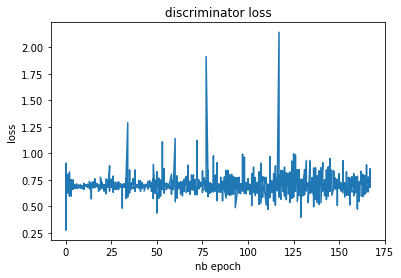

In [ ]:
with open ('/content/gdrive/MyDrive/discriminator.csv', newline='') as myfile:
  data=list(csv.reader(myfile))
loss=np.array([float(data[i][2]) for i in range (1,len(data),28)])
epoch=np.array([float(data[i][0]) for i in range (1,len(data),28)])
plt.xlabel("nb epoch")
plt.ylabel("loss")
plt.title("discriminator loss")
plt.plot(epoch,loss)

# Load Discriminator

In [ ]:
def load_Discriminator():
  file_model = '/content/gdrive/MyDrive/discriminator.pkl'
  if os.path.isfile(file_model):
      generator = torch.load(file_model)
      print("    - model restored from file....")
      print("    - filename = %s" % file_model)
      return generator
  else:
      print("unable to load dicriminator.pkl model file")
      return 0

# **Visualisation Dicriminator**

In [ ]:
model_D = load_Discriminator()
summary(model_D, input_size=( 4, 323, 792))

    - model restored from file....
    - filename = /content/gdrive/MyDrive/discriminator.pkl
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 161, 396]           4,160
         LeakyReLU-2         [-1, 64, 161, 396]               0
         Dropout2d-3         [-1, 64, 161, 396]               0
            Conv2d-4         [-1, 128, 80, 198]         131,200
         LeakyReLU-5         [-1, 128, 80, 198]               0
         Dropout2d-6         [-1, 128, 80, 198]               0
            Conv2d-7          [-1, 256, 40, 99]         524,544
         LeakyReLU-8          [-1, 256, 40, 99]               0
         Dropout2d-9          [-1, 256, 40, 99]               0
           Conv2d-10          [-1, 512, 20, 49]       2,097,664
        LeakyReLU-11          [-1, 512, 20, 49]               0
        AvgPool2d-12            [-1, 512, 1, 1]               0
         

In [ ]:
from torchviz import make_dot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
img_data = CityscapesDataset(args.datadir, split='train', mode='fine', augment=True)
discriminator = s4GAN_discriminator(img_data.num_classes)
if cuda:
    discriminator.cuda()

imgs=LabeledDataset()
real_imgs = Variable(imgs[1])
real_disc = discriminator(real_imgs.cuda().view(1, 4, 323, 792))
make_dot(real_disc).render("/content/gdrive/MyDrive/attached2", format="png")

'/content/gdrive/MyDrive/attached2.png'

# **Up Date UNET Model With Unlabeled Image:**

In [ ]:
datadir="/content/leftImg8bit/test/"
lr = 0.0002
# our transform that is applied to all incoming images
transform_image = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(128, 256), interpolation=Image.BILINEAR),
    torchvision.transforms.ToTensor()
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False
adversarial_loss = torch.nn.BCELoss()


# load the images in the folder
img_data = torchvision.datasets.ImageFolder(root=datadir, transform=transform_image)
img_batch = torch.utils.data.DataLoader(img_data, batch_size=args.batch_size, shuffle=False, num_workers=4)
print(img_data)

# load pretrained model if it is there
print("loading unet model...")
generator = []
generator=load_UNET()
discriminator=load_Discriminator()
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
# make the result directory
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# Loop through the dataset and evaluate how well the network predicts
print("\nevaluating network (will take a while)...")
for idx_batch, (imagergb, labelrgb) in enumerate(img_batch):

    # send to the GPU and do a forward pass
    x = Variable(imagergb).cuda(0)
    y = generator.forward(x)

    # enforce that we are only doing segmentation network type
    if args.losstype != "segment":
        print("this test script only works for \"segment\" unet classification...")
        exit()

    # max over the classes should be the prediction
    # our prediction is [N, classes, W, H]
    # so we max over the second dimension and take the max response
    pred_class = torch.zeros((y.size()[0], y.size()[2], y.size()[3]))
    for idx in range(0, y.size()[0]):
        pred_class[idx] = torch.argmax(y[idx], dim=0).cpu().int()

    # unsqueese so we have [N, 1, W, H] size
    # this allows for debug saving of the images to file...
    pred_class = pred_class.unsqueeze(1).float()

    # debug saving generated classes to file
    #v_utils.save_image(pred_class.float()/y.size()[1], "/content/gdrive/Shareddrives/inesk/predict/gen_image_{}_{}.png".format(0, idx_batch))
    #v_utils.save_image(x.cpu().data, "/content/gdrive/Shareddrives/inesk/predict/original_image_{}_{}.png".format(0, idx_batch))
    im1 = x.cpu().data
    im2 = pred_class.float()/y.size()[1]
    trans=transforms.ToPILImage()
    im = trans(im1[0])
    for i in range (1,5):
      im = get_concat_h(im, trans(im1[i]))
    for i in range (5):
      im = get_concat_h(im, trans(im2[i]))

    fake = Variable(Tensor(1, 1).fill_(0.0), requires_grad=False)

    im = im.resize((2584, 132))
    #optimizer_D.zero_grad()
    # Measure discriminator's ability to classify real from generated samples
    #loss = adversarial_loss(discriminator(im, fake))
    trans1 = transforms.ToTensor()
    im=trans1(im)
    save_image(im, "/content/gdrive/MyDrive/image.png")
    loss_D = adversarial_loss(discriminator(im.cuda().view(1, 4, 323, 792))[0], fake)
    #print(loss_D)
    loss_D.backward()
    print(loss_D)
    gen_optimizer.step()
    file_model = '/content/gdrive/MyDrive/unet.pkl'
    torch.save(generator, file_model)

Dataset ImageFolder
    Number of datapoints: 1525
    Root location: /content/leftImg8bit/test/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 256), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
loading unet model...
    - model restored from file....
    - filename = /content/gdrive/MyDrive/unet.pkl
    - model restored from file....
    - filename = /content/gdrive/MyDrive/discriminator.pkl

evaluating network (will take a while)...
tensor(0.8132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6578, device='cuda:0', grad_fn=<BinaryCrossEntropyBackw

In [ ]:
# cityscapes dataset loading
img_data = CityscapesDataset(args.datadir, split='val', mode='fine', augment=False)
img_batch = torch.utils.data.DataLoader(img_data, batch_size=args.batch_size, shuffle=False, num_workers=4)
print(img_data)

# initiate generator and optimizer
print("creating unet model...")
generator = nn.DataParallel(UNET(3, img_data.num_classes), device_ids=[i for i in range(args.num_gpu)]).cuda()

# load pretrained model if it is there
generator=load_UNET()

# Loop through the dataset and evaluate how well the network predicts
print("\nevaluating network (will take a while)...")
history_accuracy = []
history_time = []
for idx_batch, (imagergb, label_class, labelrgb) in enumerate(img_batch):

    # send to the GPU and do a forward pass
    start_time = time.time()
    x = Variable(imagergb).cuda(0)
    y_ = Variable(label_class).cuda(0)
    y = generator.forward(x)
    end_time = time.time()

    # we "squeeze" the groundtruth if we are using cross-entropy loss
    # this is because it expects to have a [N, W, H] image where the values
    # in the 2D image correspond to the class that that pixel should be 0 < pix[u,v] < classes
    if args.losstype == "segment":
        y_ = torch.squeeze(y_)

    # max over the classes should be the prediction
    # our prediction is [N, classes, W, H]
    # so we max over the second dimension and take the max response
    # if we are doing rgb reconstruction, then just directly save it to file
    pred_class = torch.zeros((y.size()[0], y.size()[2], y.size()[3]))
    if args.losstype == "segment":
        for idx in range(0, y.size()[0]):
            pred_class[idx] = torch.argmax(y[idx], dim=0).cpu().int()
            #pred_rgb[idx] = img_data.class_to_rgb(maxindex)
    else:
        print("this test script only works for \"segment\" unet classification...")
        exit()

    # unsqueese so we have [N, 1, W, H] size
    # this allows for debug saving of the images to file...
    pred_class = pred_class.unsqueeze(1).float()
    label_class = label_class.unsqueeze(1).float()

    # now compare the groundtruth to the predicted
    # we should record the accuracy for the class
    acc_sum = (pred_class == label_class).sum()
    acc = float(acc_sum) / (label_class.size()[0]*label_class.size()[2]*label_class.size()[3])
    history_accuracy.append(acc)
    history_time.append((end_time-start_time))

    # debug saving generated classes to file
    v_utils.save_image(pred_class.float()/img_data.num_classes, "/content/gdrive/MyDrive/testup/gen_image_{}_{}.png".format(0, idx_batch))
    v_utils.save_image(label_class.float()/img_data.num_classes, "/content/gdrive/MyDrive/testup/label_image_{}_{}.png".format(0, idx_batch))
    v_utils.save_image(x.cpu().data, "/content/gdrive/MyDrive/testup/original_image_{}_{}.png".format(0, idx_batch))

# finally output the accuracy
print("\nNETWORK RESULTS")
print("    - avg timing = %.4f (sec)" % (sum(history_time)/len(history_time)))
print("    - avg accuracy = %.4f" % (sum(history_accuracy)/len(history_accuracy)))

Dataset CityscapesDataset
    Number of images: 500
    Split: val
    Mode: gtFine
    Augment: False
    Root Location: /content/

creating unet model...
    - model restored from file....
    - filename = /content/gdrive/MyDrive/unet.pkl

evaluating network (will take a while)...

NETWORK RESULTS
    - avg timing = 0.0271 (sec)
    - avg accuracy = 0.9436


In [ ]:
i=0
a=0
for ge in sorted(listdir("/content/gdrive/MyDrive/testup")):
  path = join("/content/gdrive/MyDrive/testup", ge)
  if ge[0:3] == "gen":
    path1="/content/gdrive/MyDrive/testup/label_image" + ge[9:]
    a+=calcule_miou1(path, path1)
    i=i+1
print(a/i)

0.8700579844875402


# **MLMT Part :**

In [ ]:
resnet = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


In [ ]:
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
out = resnet(x)
make_dot(out).render("/content/gdrive/MyDrive/resnett", format="png")

'/content/gdrive/Shareddrives/inesk/resnett.png'

In [ ]:
img_cat = Image.open("/content/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png").convert('RGB')

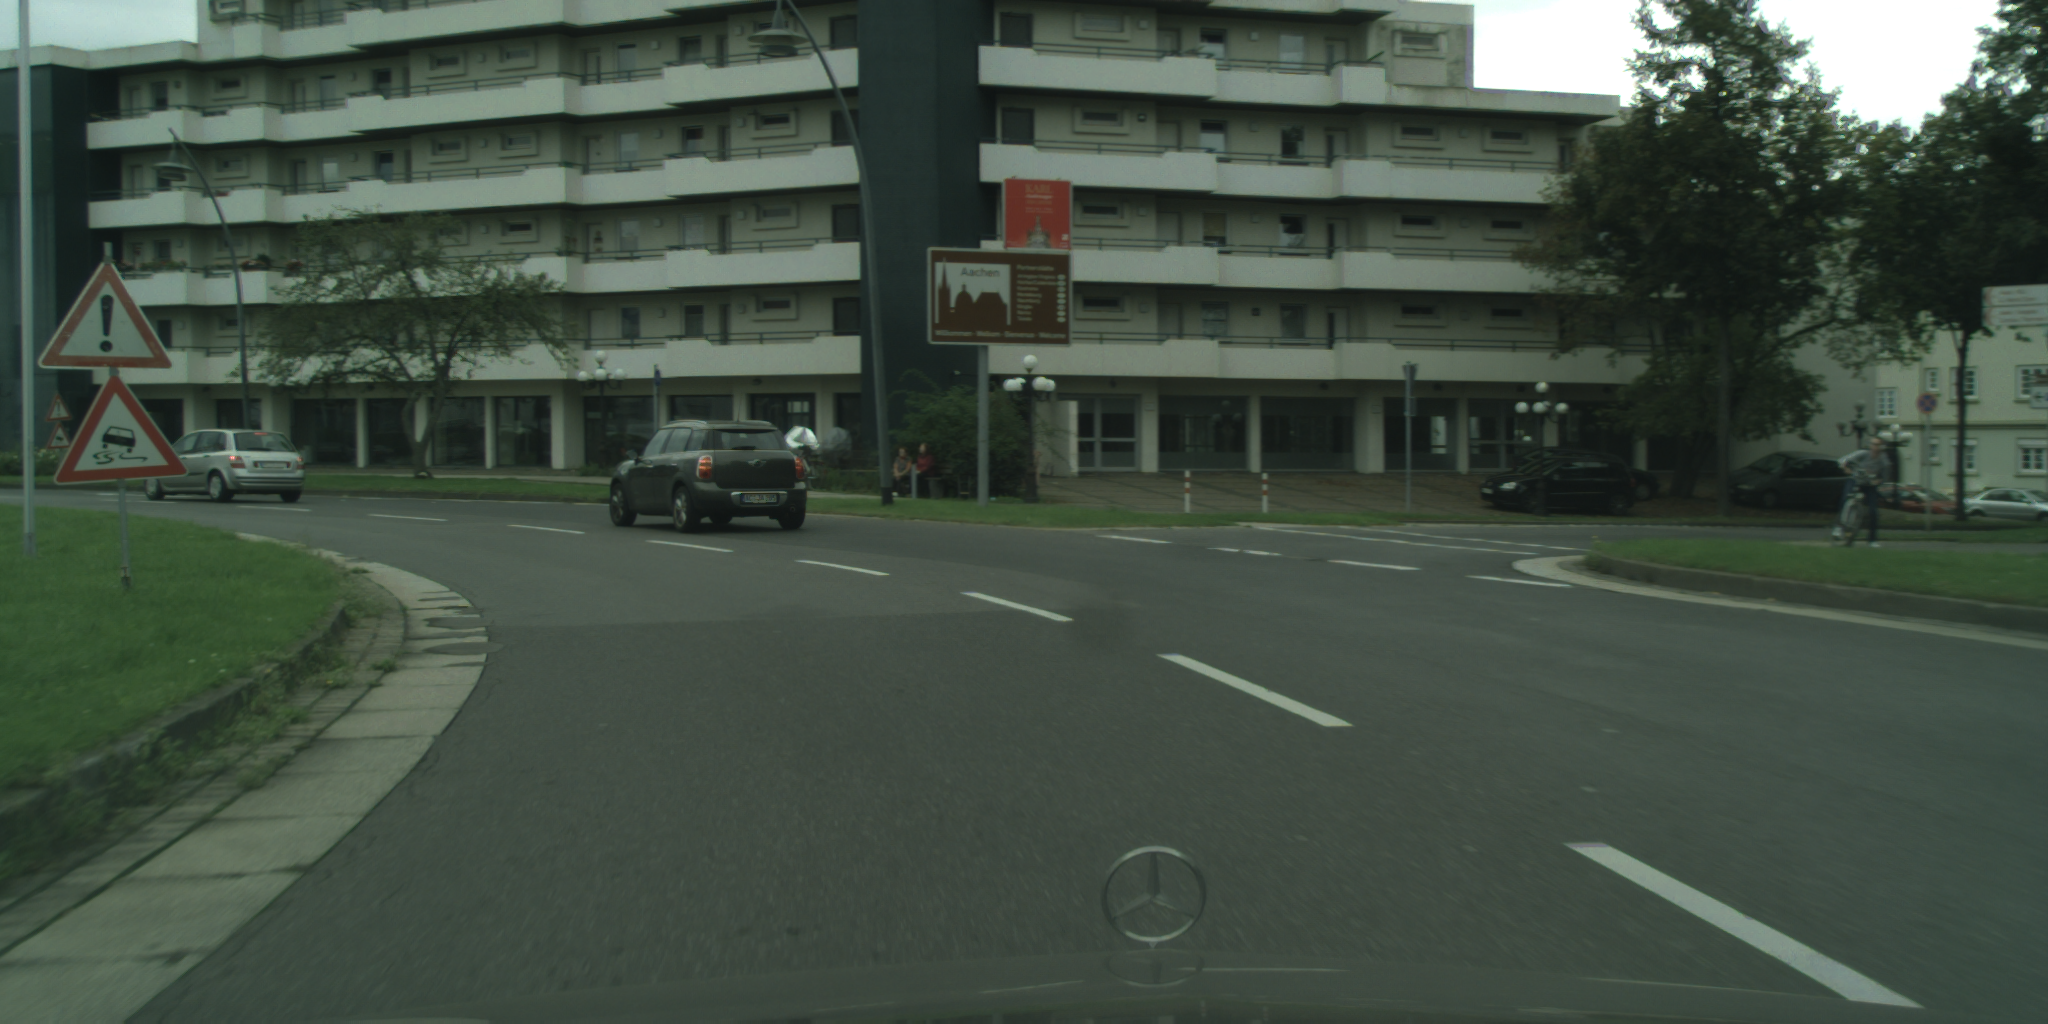

In [ ]:
img_cat

In [ ]:

#
# Create a preprocessing pipeline
#
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
#
# Pass the image for preprocessing and the image preprocessed
#
img_cat_preprocessed = preprocess(img_cat)
#
# Reshape, crop, and normalize the input tensor for feeding into network for evaluation
#
batch_img_cat_tensor = torch.unsqueeze(img_cat_preprocessed, 0)

In [ ]:
#
# Resnet is required to be put in evaluation mode in order
# to do prediction / evaluation
#
resnet.eval()
#
# Get the predictions of image as scores related to how the loaded image
# matches with 1000 ImageNet classes. The variable, out is a vector of 1000 scores
#
out = resnet(batch_img_cat_tensor)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# Load the file containing the 1,000 labels for the ImageNet dataset classes
#
with open('/content/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]
#
# Find the index (tensor) corresponding to the maximum score in the out tensor.
# Torch.max function can be used to find the information
#
_, index = torch.max(out, 1)
#
# Find the score in terms of percentage by using torch.nn.functional.softmax function
# which normalizes the output to range [0,1] and multiplying by 100
#
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
#
# Print the name along with score of the object identified by the model
#
print(labels[index[0]], percentage[index[0]].item())
#
# Print the top 5 scores along with the image label. Sort function is invoked on the torch to sort the scores.
#
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

library 16.499034881591797


[('library', 16.499034881591797),
 ('bubble', 6.38719367980957),
 ('garbage truck, dustcart', 6.221591949462891),
 ('traffic light, traffic signal, stoplight', 4.163507461547852),
 ('golf ball', 3.810269832611084)]

# **Load VOC_Dataset**

In [ ]:
!wget https://download.pytorch.org/models/resnet101-5d3b4d8f.pth

--2021-08-11 12:06:01--  https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
Resolving download.pytorch.org (download.pytorch.org)... 99.86.37.37, 99.86.37.116, 99.86.37.53, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.37.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178728960 (170M) [application/octet-stream]
Saving to: ‘resnet101-5d3b4d8f.pth’

resnet101-5d3b4d8f. 100%[===================>] 170.45M  74.8MB/s    in 2.3s    

2021-08-11 12:06:03 (74.8 MB/s) - ‘resnet101-5d3b4d8f.pth’ saved [178728960/178728960]



In [ ]:
!wget https://lmb.informatik.uni-freiburg.de/resources/datasets/voc_dataset.tar.gz

--2021-08-11 12:06:08--  https://lmb.informatik.uni-freiburg.de/resources/datasets/voc_dataset.tar.gz
Resolving lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)... 132.230.167.23
Connecting to lmb.informatik.uni-freiburg.de (lmb.informatik.uni-freiburg.de)|132.230.167.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1944076072 (1.8G) [application/x-gzip]
Saving to: ‘voc_dataset.tar.gz’

voc_dataset.tar.gz  100%[===================>]   1.81G  6.02MB/s    in 4m 33s  

2021-08-11 12:10:42 (6.80 MB/s) - ‘voc_dataset.tar.gz’ saved [1944076072/1944076072]



In [ ]:
!tar -xvf '/content/voc_dataset.tar.gz'


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
voc_dataset/JPEGImages/2009_003865.jpg
voc_dataset/JPEGImages/2012_004159.jpg
voc_dataset/JPEGImages/2012_000960.jpg
voc_dataset/JPEGImages/2008_007043.jpg
voc_dataset/JPEGImages/2008_000473.jpg
voc_dataset/JPEGImages/2008_007981.jpg
voc_dataset/JPEGImages/2008_008096.jpg
voc_dataset/JPEGImages/2008_002071.jpg
voc_dataset/JPEGImages/2009_000435.jpg
voc_dataset/JPEGImages/2007_003195.jpg
voc_dataset/JPEGImages/2008_000835.jpg
voc_dataset/JPEGImages/2012_002833.jpg
voc_dataset/JPEGImages/2007_008142.jpg
voc_dataset/JPEGImages/2009_001146.jpg
voc_dataset/JPEGImages/2010_005586.jpg
voc_dataset/JPEGImages/2011_000002.jpg
voc_dataset/JPEGImages/2008_003477.jpg
voc_dataset/JPEGImages/2011_007079.jpg
voc_dataset/JPEGImages/2008_001267.jpg
voc_dataset/JPEGImages/2011_004905.jpg
voc_dataset/JPEGImages/2009_001608.jpg
voc_dataset/JPEGImages/2010_005616.jpg
voc_dataset/JPEGImages/2010_003826.jpg
voc_dataset/JPEGImages/20